# Interpolated traces

In [2]:
import numpy as np
import pandas as pd

import scipy.interpolate

import matplotlib.pyplot as plt

from tqdm import tqdm

## Load data

In [3]:
# Load Wacom tablet dump
tablet_df = pd.read_csv("../data/set1_tab.csv", encoding="utf_16_le")
tablet_df

,host_timestamp,x,y,z,in_range,touch,pressure,reset
0,43375067069000,-125.000000,727.000000,0,0,0,0,0
1,43375085835600,-125.000000,727.000000,0,0,0,0,0
2,43375103211700,-125.000000,727.000000,0,0,0,0,0
3,43375119624300,-125.000000,727.000000,0,0,0,0,0
4,43375136587100,-125.000000,727.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...
57262,44224171305000,421.307164,117.212863,0,0,0,0,0
57263,44224187636300,421.307164,117.212863,0,0,0,0,0
57264,44224204691800,421.307164,117.212863,0,0,0,0,0
57265,44224219941300,421.307164,117.212863,0,0,0,0,0


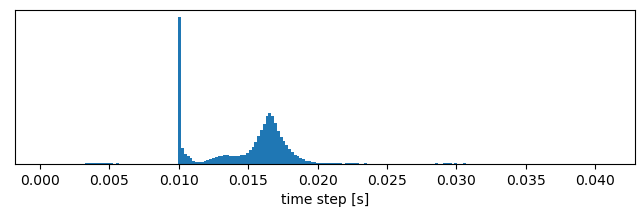

In [4]:
# Show timestep distribution
_, ax = plt.subplots(figsize=(8, 2))
ax.hist(tablet_df["host_timestamp"].diff() * 1e-9, bins=200, density=True)
ax.set_xlabel("time step [s]")
ax.set_yticks([])
plt.show()

In [5]:
# How many segments were reported?
boundaries, = np.where(tablet_df["reset"] == 1)
len(boundaries)

51

## Non-linear interpolation

In [6]:
# Select arbitrary example
index = 32
chunk_df = tablet_df.iloc[boundaries[index]:boundaries[index+1]].copy()

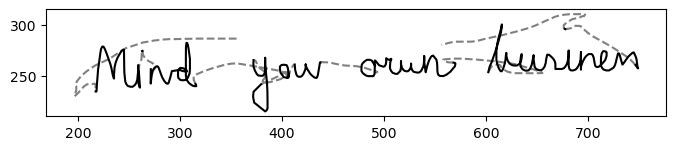

In [7]:
# Show it
_, ax = plt.subplots(figsize=(8, 2))
is_touch = chunk_df["touch"] > 0
is_on = is_touch | is_touch.shift(1)
is_off = ~is_touch | (~is_touch).shift(1)
ax.plot(chunk_df["x"].where(is_on), chunk_df["y"].where(is_on), c="k")
ax.plot(chunk_df["x"].where(is_off), chunk_df["y"].where(is_off), c="gray", ls="--", zorder=-1)
ax.set_aspect("equal")
#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

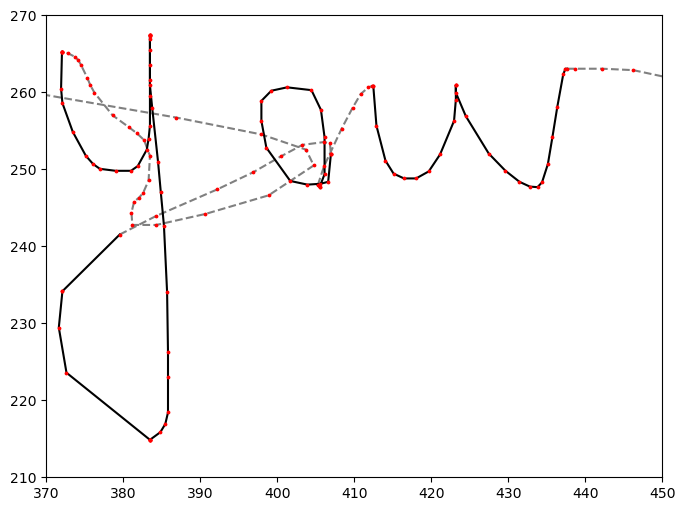

In [8]:
# Zoom on a single chunk
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(chunk_df["x"].where(is_on), chunk_df["y"].where(is_on), c="k")
ax.plot(chunk_df["x"].where(is_off), chunk_df["y"].where(is_off), c="gray", ls="--", zorder=-1)
ax.scatter(chunk_df["x"], chunk_df["y"], c="r", s=3, zorder=10)
ax.set_aspect("equal")
ax.set_xlim(370, 450)
ax.set_ylim(210, 270)
#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

In [9]:
# Compute distance between two points
chunk_df["d"] = np.sqrt(chunk_df["x"].diff() ** 2 + chunk_df["y"].diff() ** 2)

# Drop points that are too close, as it affect spline computation
chunk_df = chunk_df[chunk_df["d"] > 1e-5].copy()

# Use cumulative distance as spline "timestamp"
# Note: actual pen velocity (related to "host_timestamp") is not really relevant for polyline smoothing
chunk_df["t"] = chunk_df["d"].cumsum()
length = chunk_df["t"].iloc[-1]

In [10]:
# Fit cubic spline
smoothness = 200
step = 0.1
tck, _ = scipy.interpolate.splprep([chunk_df["x"].values, chunk_df["y"].values], u=chunk_df["t"].values, s=smoothness)
t = np.arange(0, length, step)
x, y = scipy.interpolate.splev(t, tck, der=0)

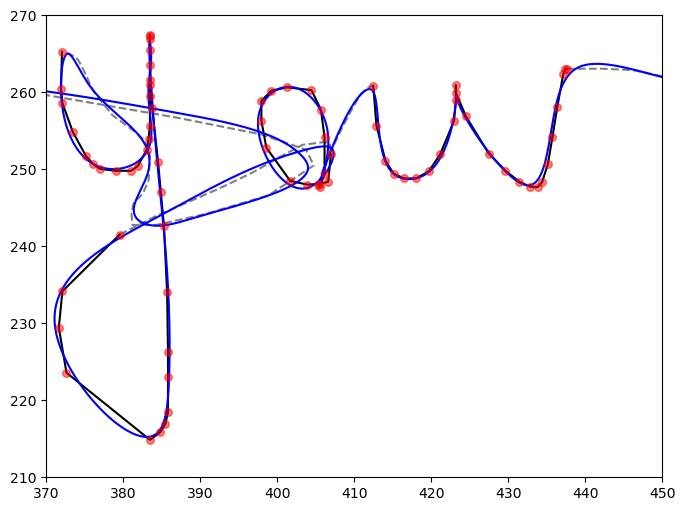

In [11]:
# Overlay on chunk
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(chunk_df["x"].where(is_on), chunk_df["y"].where(is_on), c="k")
ax.plot(chunk_df["x"].where(is_off), chunk_df["y"].where(is_off), c="gray", ls="--", zorder=-1)
ax.scatter(chunk_df["x"].where(is_on), chunk_df["y"].where(is_on), c="r", s=30, zorder=10, alpha=0.5)
ax.plot(x, y, c="b")
ax.set_aspect("equal")
ax.set_xlim(370, 450)
ax.set_ylim(210, 270)
#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

In [12]:
# Assign whether the pen is touching the tablet surface, on the spline
p = chunk_df["touch"].iloc[np.searchsorted(chunk_df["t"], t)]

# Do as above
is_touch = p > 0
is_on = is_touch | is_touch.shift(1)
is_off = ~is_touch | (~is_touch).shift(1)

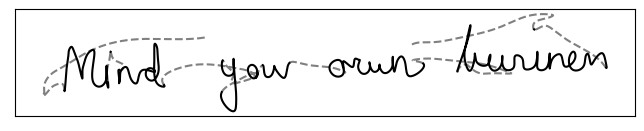

In [13]:
# Show it
_, ax = plt.subplots(figsize=(8, 2))
ax.plot(np.where(is_on, x, np.nan), np.where(is_on, y, np.nan), c="k")
ax.plot(np.where(is_off, x, np.nan), np.where(is_off, y, np.nan), c="gray", ls="--", zorder=-1)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Process whole sequence

In [14]:
# Tablet data is only reliable when in close range
# Note: also segmenting at resets, when in range
is_entering_range = tablet_df["in_range"].diff() == 1
is_reset_in_range = (tablet_df["in_range"] == 1) & (tablet_df["reset"] == 1)
is_start_of_segment = is_entering_range | is_reset_in_range
is_start_of_segment.sum()

71

In [15]:
# Number segments
tablet_df["segment"] = is_start_of_segment.cumsum() - 1

In [16]:
# Ignore parts that are out-of-range
tablet_df = tablet_df[tablet_df["in_range"] == 1].drop(columns=["in_range", "reset"]).copy()

In [17]:
def interpolate(df, *, smoothness=200, step=1.0):
    
    # Compute distance
    x = df["x"].values
    y = df["y"].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    d = np.sqrt(dx ** 2 + dy ** 2)
    t = np.cumsum(d)
    length = t[-1]
    
    # Fit cubic splines
    mask = d > 1e-5
    if mask.sum() <= 3:
        return None
    tck, _ = scipy.interpolate.splprep([x[mask], y[mask]], u=t[mask], s=smoothness)
    
    # Sample spline at regular (spatial) interval
    t_r = np.arange(0, length, step)
    x_r, y_r = scipy.interpolate.splev(t_r, tck, der=0)
    
    # Resample other values linearly
    host_timestamp_r = np.interp(t_r, t, df["host_timestamp"])
    z_r = np.interp(t_r, t, df["z"])
    pressure_r = np.interp(t_r, t, df["pressure"])
    
    # Since `touch` is a boolean, use nearest neighbor instead
    touch_r = df["touch"].iloc[np.searchsorted(t, t_r)]
    
    # Rebuild frame
    df_r = pd.DataFrame({
        "host_timestamp": host_timestamp_r,
        "x": x_r,
        "y": y_r,
        "z": z_r,
        "touch": touch_r,
        "pressure": pressure_r,
    }).reset_index(drop=True)
    return df_r

In [18]:
# Select arbitrary example
df = tablet_df[tablet_df["segment"] == 11]

In [19]:
# Resample at various smoothness
df_r_low = interpolate(df, smoothness=100.0, step=0.1)
df_r_high = interpolate(df, smoothness=1000.0, step=0.1)

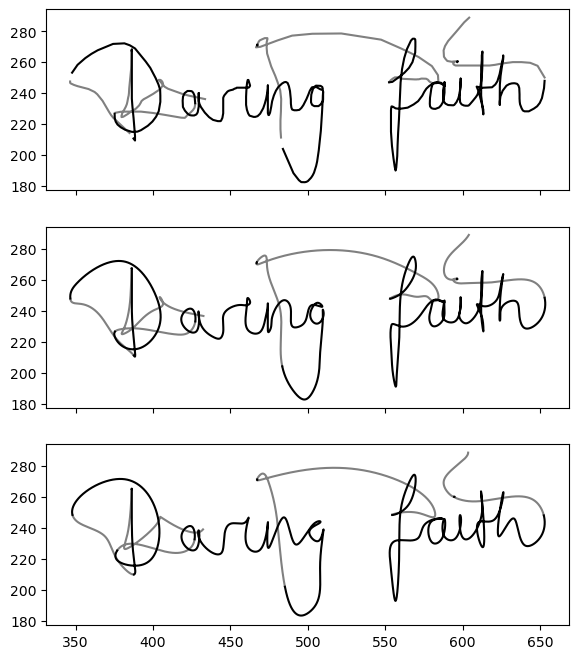

In [20]:
# Show it
_, axes = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 8))

is_touch = df["touch"] == 1
axes[0].plot(df["x"].where(is_touch), df["y"].where(is_touch), c="k")
axes[0].plot(df["x"].where(~is_touch), df["y"].where(~is_touch), c="gray", zorder=-1)
axes[0].set_aspect("equal")

is_touch = df_r_low["touch"] == 1
axes[1].plot(df_r_low["x"].where(is_touch), df_r_low["y"].where(is_touch), c="k")
axes[1].plot(df_r_low["x"].where(~is_touch), df_r_low["y"].where(~is_touch), c="gray", zorder=-1)
axes[1].set_aspect("equal")

is_touch = df_r_high["touch"] == 1
axes[2].plot(df_r_high["x"].where(is_touch), df_r_high["y"].where(is_touch), c="k")
axes[2].plot(df_r_high["x"].where(~is_touch), df_r_high["y"].where(~is_touch), c="gray", zorder=-1)
axes[2].set_aspect("equal")

plt.show()

In [21]:
# Process the whole table
resampled_df = tablet_df.groupby("segment").apply(interpolate, smoothness=100, step=0.5)
resampled_df

host_timestamp           x           y             z  touch  \
segment                                                                    
0       0      4.337721e+13  229.200080   79.192716  20991.000000      0   
        1      4.337721e+13  227.786868   79.134908  20724.138066      0   
        2      4.337721e+13  226.405109   79.088273  20457.276133      0   
        3      4.337721e+13  225.054467   79.052703  20190.414199      0   
        4      4.337721e+13  223.734605   79.028091  19923.552266      0   
...                     ...         ...         ...           ...    ...   
70      412    4.421990e+13  422.744773  115.751616  15176.879539      0   
        413    4.421990e+13  422.314016  116.119044  16040.795840      0   
        414    4.421990e+13  421.883172  116.478317  16904.712141      0   
        415    4.421990e+13  421.452717  116.828826  17768.628442      0   
        416    4.421990e+13  421.023126  117.169965  18632.544742      0   

             pressure  
segment                
0       0         0.0  
        1         0.0  
        2         0.0  
        3         0.0  
        4         0.0  
...               ...  
70      412       0.0  
        413       0.0  
        414       0.0  
        415       0.0  
        416       0.0  

[246176 rows x 6 columns]

## Position step distribution

c:\Users\ann-k\anaconda3\envs\patternRecognition\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


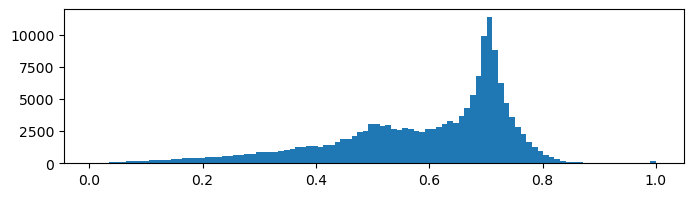

In [22]:
# Actual step distance distribution
_, ax = plt.subplots(figsize=(8, 2))
ax.hist(np.sqrt(resampled_df["x"].diff() ** 2 + resampled_df["y"].diff()).clip(0, 1), bins=100)
plt.show()

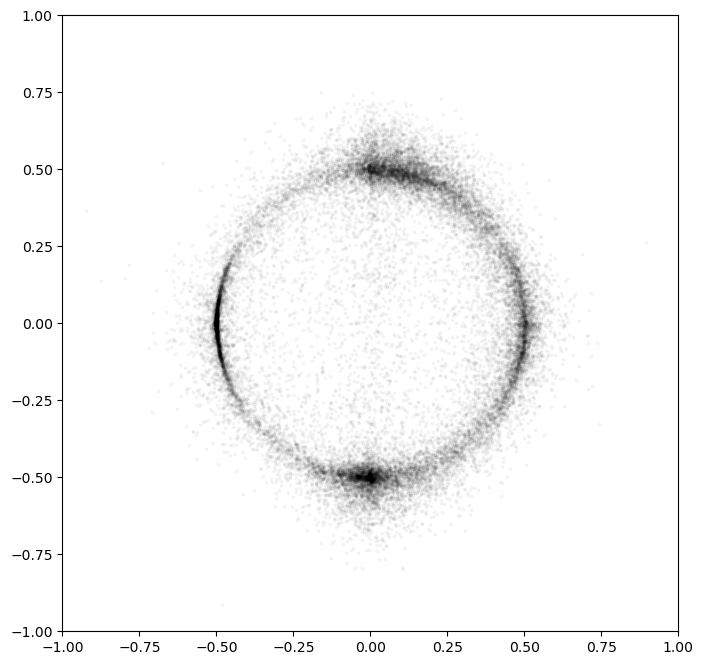

In [23]:
# Derivative distribution
_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(resampled_df["x"].diff().iloc[::10], resampled_df["y"].diff().iloc[::10], s=3, c="k", alpha=0.03)
ax.set_aspect("equal")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()

In [24]:
# TODO more analysis and visualization